# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
06/22/2016 06:58:05  06/23/2016 06:58:05  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 06/22/2016 06:58:05


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-06-20 06:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-06-22 06:58 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-25 06:28 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [2]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName("eval")

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "100")
#sconf.set("spark.executor.memory", "20")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set('spark.yarn.isPython', True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
#sconf.set("spark.yarn.access.namenodes", "hdfs://head02.hathi.surfsara.nl:8020")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")
#sconf.set("spark.driver.host", "145.100.59.88")

sconf.set('spark.rdd.compress', False)

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    #sendNotificationToMattia("Spark Context", str(sc))
except Exception, err:
    #sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

Py4JNetworkError: An error occurred while trying to connect to the Java server

In [4]:
sc.parallelize(range(1000)).take(3)

NameError: name 'sc' is not defined

# <hr style="clear: both" />

# Now you can run your code

Pick a clustering algorithm (name of the file that provides a classify(x,y [,threshold]) function)

In [6]:
execfile('../spark-scripts/evalCluster.py')
execfile('../spark-scripts/utilsCluster.py')


import json
import copy
import pandas as pd
import numpy as np

BASE_PATH = HDFS_PATH + '/user/robertop/mattia'

conf = {}

conf['split'] = {}
conf['split']['reclistSize'] = 100
conf['split']['callParams'] = {}
conf['split']['excludeAlreadyListenedTest'] = True
conf['split']['name'] = 'SenzaRipetizioni_1'
conf['split']['split'] = conf['split']['name']
conf['split']['minEventsPerUser'] = 5
conf['split']['inputData'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/SenzaRipetizioni_1'
#conf['split']['inputData'] = 's3n://contentwise-research-poli/30musicdataset/newFormat/relations/sessions.idomaar'
conf['split']['bucketName'] = BASE_PATH
conf['split']['percUsTr'] = 0.05
conf['split']['ts'] = int(0.75 * (1421745857 - 1390209860) + 1390209860) - 10000
conf['split']['minEventPerSession'] = 5
conf['split']['onlineTrainingLength'] = 5
conf['split']['GTlength'] = 1
conf['split']['minEventPerSessionTraining'] = 10
conf['split']['minEventPerSessionTest'] = 11
conf['split']['mode'] = 'session'
conf['split']['forceSplitCreation'] = False
conf['split']["prop"] = {'reclistSize': conf['split']['reclistSize']}
conf['split']['type'] = None
conf['split']['out'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/'
conf['split']['location'] = '30Mdataset/relations/sessions'

conf['evaluation'] = {}
conf['evaluation']['metric'] = {}
conf['evaluation']['metric']['type'] = 'recall'
conf['evaluation']['metric']['prop'] = {}
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
conf['evaluation']['name'] = 'recall@N'

conf['general'] = {}
conf['general']['clientname'] = "clusterBase.split"
conf['general']['bucketName'] = BASE_PATH
conf['general']['tracksPath'] = '30Mdataset/entities/tracks.idomaar.gz'

conf['algo'] = {}
conf['algo']['props'] = {}
# ***** EXAMPLE OF CONFIGURATION *****#
conf['algo']['props']["sessionJaccardShrinkage"] = 7.5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.2
conf['algo']['props']["expDecayFactor"] = 0.7
# ****** END EXAMPLE ****************#
clusterSim = conf['algo']['props']["clusterSimilarityThreshold"]
sessionJaccardShrinkage = conf['algo']['props']["sessionJaccardShrinkage"]
expDecay = conf['algo']['props']["expDecayFactor"]

conf['split']['excludeAlreadyListenedTest'] = str(True)



# Load Original Algo

In [4]:
execfile('../spark-scripts/evalClusterNew.py')
execfile('../spark-scripts/utilsCluster.py')

conf['algo']['props']["sessionJaccardShrinkage"] = 5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.1
conf['algo']['props']["expDecayFactor"] = 0.7
clusterSim = conf['algo']['props']["clusterSimilarityThreshold"]
sessionJaccardShrinkage = conf['algo']['props']["sessionJaccardShrinkage"]
expDecay = conf['algo']['props']["expDecayFactor"]

CLUSTER_ALGO = 'plain'
THRESHOLD = '0.0'
THRESHOLD_STR = str(THRESHOLD)[2:]
conf['algo']['name'] = CLUSTER_ALGO + THRESHOLD_STR + '_ImplicitPlaylist_shk_%d_clustSim_%.3f_decay_%.3f' % \
                    (sessionJaccardShrinkage, clusterSim, expDecay )

recOriginalRDD = loadRecommendations(conf)
recOriginalRDD.count()
recOriginalRDD.unpersist()

NameError: name 'conf' is not defined

# Load cluster Algo

In [4]:
execfile('../spark-scripts/evalClusterNew.py')
execfile('../spark-scripts/utilsCluster.py')

conf['algo']['props']["sessionJaccardShrinkage"] = 7.5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.2
conf['algo']['props']["expDecayFactor"] = 0.7
clusterSim = conf['algo']['props']["clusterSimilarityThreshold"]
sessionJaccardShrinkage = conf['algo']['props']["sessionJaccardShrinkage"]
expDecay = conf['algo']['props']["expDecayFactor"]

CLUSTER_ALGO = 'collaborative/'
THRESHOLD = '0.min_j_25_avgShrink2_higherMean'
THRESHOLD_STR = str(THRESHOLD)[2:]

conf['algo']['name'] = CLUSTER_ALGO + THRESHOLD_STR + '_ImplicitPlaylist_shk_%d_clustSim_%.3f_decay_%.3f' % \
                    (sessionJaccardShrinkage, clusterSim, expDecay )
    
recCluster = loadRecommendations(conf).map(json.loads)
    
cluster_path = BASE_PATH + "/clusters/" + CLUSTER_ALGO + THRESHOLD_STR
clustersRDD = sc.pickleFile(cluster_path)

recClusterRDD = mapClusterRecToListOfSongs(recCluster, clustersRDD, 'plug_songs')
recClusterRDD.count()

242956

# Sessions Scores

In [ ]:
execfile('../spark-scripts/evalClusterNew.py')
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
originalSessHits = computeHitSessions(conf, recOriginalRDD)
clusterSessHits = computeHitSessions(conf, recClusterRDD)

originalSessHits.saveAsPickleFile(BASE_PATH + '/tmp/originalSessHits')
clusterSessHits.saveAsPickleFile(BASE_PATH + '/tmp/clusterSessHits')


In [151]:
originalSessHits = sc.pickleFile(BASE_PATH + '/tmp/originalSessHits')
clusterSessHits = sc.pickleFile(BASE_PATH + '/tmp/clusterSessHits')

In [152]:
originalSessHits.subtractByKey(cl)

[(1, (4020301417197576, 0, 100)), (1, (2828401421723660, 0, 100))]

In [ ]:
for n in conf['evaluation']['metric']['prop']['N']:
    original = originalSessHits.filter(lambda x: x[0] == n).map(lambda x: (x[1][0], (x[1][1], x[1][2])))
    cluster = clusterSessHits.filter(lambda x: x[0] == n).map(lambda x: (x[1][0], (x[1][1], x[1][2])))
    
    compare = original.join(cluster)
    compare.saveAsPickleFile(BASE_PATH + '/tmp/joinSessionHits@' + str(n))
    


In [8]:
originalCount = originalSessHits.count()
clusterCount = clusterSessHits.count()

In [11]:
clusterCount - originalCount

-100512

In [6]:
plus_cluster = {}
plus_original = {}

In [7]:
for n in [1,2,5,10,15,20,25,50,100]:
    compare = sc.pickleFile(BASE_PATH + '/tmp/joinSessionHits@' + str(n))
    diff = compare.map(lambda x: (x[0], x[1][1][0] - x[1][0][0], x[1][1][1] - x[1][0][1] ) )
    
    print n
    print diff.take(1)
    
    plus_cluster[n] = diff.filter(lambda x: x[1] > 0).collect()
    plus_original[n] = diff.filter(lambda x: x[1] < 0).collect()
    

1
[(2740501421004320, -1, 0)]
2
[(287601414470400, 0, 0)]
5
[(1902901415311264, 0, 0)]
10
[(1902901415311264, 0, 0)]
15
[(1902901415311264, 0, 0)]
20
[(2740501421004320, -1, 0)]
25
[(2740501421004320, -1, 0)]
50
[(2740501421004320, -1, 0)]
100
[(2740501421004320, 0, 0)]


In [69]:
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 20}  


font_labels = {'family': 'serif',
                   'weight': 'normal',
                   'size': 14}   

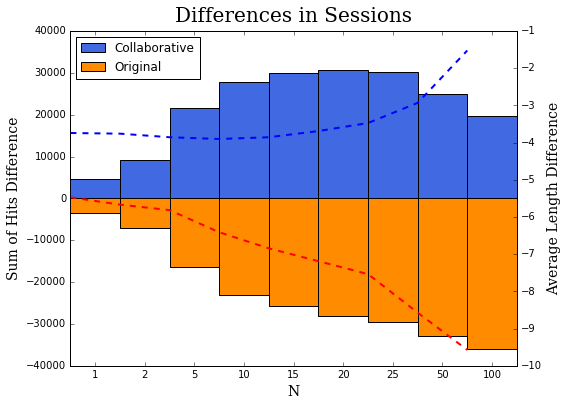

In [91]:
from matplotlib import pyplot as plt
%matplotlib inline

N = [1,2,5,10,15,20,25,50,100]
x = range(len(N))

positives = []
negatives = []

for i in N:
    p = sum([j[1] for j in plus_cluster[i]])
    n = sum([j[1] for j in plus_original[i]])
    positives.append(p)
    negatives.append(n)
    
clust_length = []
original_length = []

for k,i in enumerate(N):
    clust_length.append( np.mean([j[2] for j in plus_cluster[i]]) )
    original_length.append( np.mean([j[2] for j in plus_original[i]]) )
    


fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
plt.title('Differences in Sessions', fontdict= font_title)
ax.bar(x, positives, width=1, color='royalblue')
ax.bar(x, negatives, width=1, color='darkorange')
ax.set_xticklabels(N)
ax.set_xticks([i + 0.5 for i in x])
ax.set_xlabel('N', fontdict=font_labels)
ax.set_ylabel('Sum of Hits Difference', fontdict=font_labels)
plt.legend(['Collaborative', 'Original'], loc=2)

ax2 = ax.twinx()
ax2.plot(x, clust_length, 'b--', linewidth = 2)
ax2.plot(x, original_length, 'r--', linewidth = 2)
ax2.set_ylabel('Average Length Difference', fontdict=font_labels)

In [81]:
plus_cluster_list = []
plus_original_list = []

for n in [1,2,5,10,15,20,25,50,100]:
    plus_cluster_list += [(n, i) for i in plus_cluster[n]]
    plus_original_list += [(n, i) for i in plus_original[n]]



In [85]:
plus_clusterRDD = sc.parallelize(plus_cluster_list)
plus_originalRDD = sc.parallelize(plus_original_list)

plus_clusterRDD.saveAsPickleFile(BASE_PATH + '/tmp/plusCluster')
plus_originalRDD.saveAsPickleFile(BASE_PATH + '/tmp/plusOriginal')

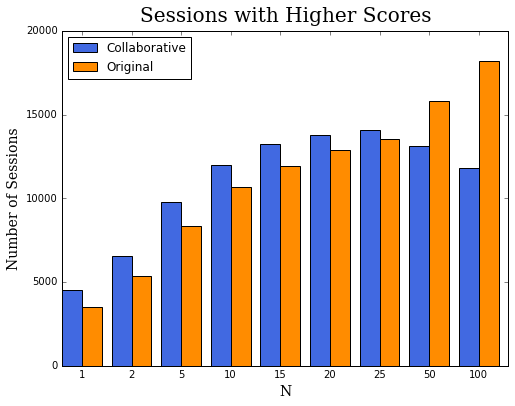

In [111]:
from matplotlib import pyplot as plt
%matplotlib inline

N = [1,2,5,10,15,20,25,50,100]
x = range(len(N))

positives = []
negatives = []

for i in N:
    positives.append(len(plus_cluster[i]))
    negatives.append(len(plus_original[i]))
    

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
plt.title('Sessions with Higher Scores', fontdict= font_title)
ax.bar(x, positives, width=0.4, color='royalblue')
ax.bar([i + 0.4 for i in x], negatives, width=0.4, color='darkorange')
ax.set_xticklabels(N)
ax.set_xticks([i + 0.4 for i in x])
ax.set_xlabel('N', fontdict=font_labels)
ax.set_ylabel('Number of Sessions', fontdict=font_labels)
plt.legend(['Collaborative', 'Original'], loc=2)


# Sessions that are better for Collaborative at 25

In [122]:
sessions_at_25 = [i[0] for i in plus_cluster[25]]

splitPath = os.path.join(conf['general']['bucketName'], conf['general']['clientname'])
    # basePath = "s3n://" + conf['general']['bucketName'] + "/"+conf['general']['clientname']+"/"
GTpath = os.path.join(splitPath, "GT")

gtRDD = sc.textFile(GTpath).map(lambda x: json.loads(x))
gtCluster25 = gtRDD.filter(lambda x: x['linkedinfo']['gt'][0]['id'] in sessions_at_25)

In [148]:
gtCluster25.count()

14102

In [123]:
inFile = path.join(conf['general']['bucketName'], conf['general']['clientname'])

test = sc.textFile(path.join(inFile, 'test/onlineTraining')).map(lambda x: json.loads(x))
testCluster25 = test.filter(lambda x: x['id'] in sessions_at_25)

# Load Clusters

In [128]:
clusterSongsFileRDD = sc.pickleFile(BASE_PATH + '/clusters/collaborative/min_j_25_avgShrink2_higherMean')

songsInClusters = clusterSongsFileRDD.filter(lambda x: len(x[1]) > 1).flatMap(lambda x: [int(i) for i in x[1]] ).collect()


In [134]:
testCluster25Songs = testCluster25.map(lambda x: (x['id'], [i['id'] for i in x['linkedinfo']['objects']]))
gtCluster25Songs = gtCluster25.map(lambda x: (x['id'], [i['id'] for i in x['linkedinfo']['objects']]))

print testCluster25Songs.take(30)
print gtCluster25Songs.take(30)

[(4292401421274706, [159324, 132923, 3592097, 1326692, 1418608]), (4253201421354356, [558897, 558892, 558861, 558860, 558839]), (3077201421142098, [1228679, 1228660, 1228874, 1228863, 1228753]), (3077201421659416, [1228874, 1228671, 1228673, 1228823, 1228859]), (999601421465510, [1219220, 2914168, 2442858, 1607778, 315418]), (3900401415988958, [2534401, 2534392, 2534336, 2534463, 2534329]), (3900401420741135, [233271, 3511821, 145680, 3618863, 92886]), (2058001415660100, [575163, 3218588, 3218595, 2909809, 2123756]), (2058001415626358, [711177, 719415, 719357, 719494, 719185]), (4272801421242950, [950488, 951148, 950745, 950910, 951127]), (4312001416624724, [2752889, 2752372, 2752764, 2752650, 2752328]), (1803201416138489, [1750339, 2854319, 2174546, 142056, 2493000]), (3038001421280605, [42070, 797982, 3840786, 3520617, 3460929]), (274401420801708, [2752889, 2752372, 2752764, 2752650, 2752328]), (431201420543748, [2423080, 2423491, 2423368, 2422747, 2422767]), (431201420798704, [11974

In [139]:
testCluster25SongsCluster = testCluster25Songs.filter(lambda x: len(set(x[1]) & set(songsInClusters)))
gtCluster25SongsCluster = gtCluster25Songs.filter(lambda x: len(set(x[1]) & set(songsInClusters)))

print testCluster25SongsCluster.count()
print gtCluster25SongsCluster.count()

51
68


In [141]:
print testCluster25SongsCluster.count()/float(testCluster25.count())*100
print gtCluster25SongsCluster.count()/float(testCluster25.count())*100

0.36165082967
0.482201106226


# Sessions better for Original at 100

In [149]:
sessions_at_100 = [i[0] for i in plus_original[100]]

gtCluster100 = gtRDD.filter(lambda x: x['linkedinfo']['gt'][0]['id'] in sessions_at_100)
testCluster100 = test.filter(lambda x: x['id'] in sessions_at_100)

print gtCluster100.count()
print testCluster100.count()

18191
18191


In [150]:
testCluster100Songs = testCluster100.map(lambda x: (x['id'], [i['id'] for i in x['linkedinfo']['objects']]))
gtCluster100Songs = gtCluster100.map(lambda x: (x['id'], [i['id'] for i in x['linkedinfo']['objects']]))

testCluster100SongsCluster = testCluster100Songs.filter(lambda x: len(set(x[1]) & set(songsInClusters)))
gtCluster100SongsCluster = gtCluster100Songs.filter(lambda x: len(set(x[1]) & set(songsInClusters)))

print testCluster100SongsCluster.count()
print gtCluster100SongsCluster.count()

67
67


# Random Switch Clusters

In [7]:
clusterSongsFileRDD = sc.pickleFile(BASE_PATH + '/clusters/collaborative/min_j_25_avgShrink2_higherMean')

singlesRDD = clusterSongsFileRDD.filter(lambda x: len(x[1]) == 1 )
clustersRDD = clusterSongsFileRDD.filter(lambda x: len(x[1]) > 1 )

In [8]:
clusters = clustersRDD.collect()
clusters[0]

(9846, [892234, 892243])

In [9]:
switch = 42

for i, elem in enumerate(clusters):
    current = elem[1].pop()
    clusters[(i+switch)%len(clusters)][1].insert(0, current)

clusterSwitchRDD = sc.parallelize(clusters)

switchedRDD = clusterSwitchRDD.union(singlesRDD)

switchedRDD.saveAsPickleFile(BASE_PATH + '/clusters/collaborative/min_j_25_avgShrink2_Switch' + str(switch))

IllegalArgumentException: u'Pathname /user/robertop/mattia/clusters/collaborative/min_j_25_avgShrink2_SwitchUnionRDD[8] at union at NativeMethodAccessorImpl.java:-2 from hdfs://hathi-surfsara/user/robertop/mattia/clusters/collaborative/min_j_25_avgShrink2_SwitchUnionRDD[8] at union at NativeMethodAccessorImpl.java:-2 is not a valid DFS filename.'